In [1]:
import numpy as np
from numba import njit
from numba_progress import ProgressBar
from tqdm import tqdm
from scipy.special import erf, erfc
from scipy.optimize import root, curve_fit
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
Tm      = 54.        # *C
Tw      = 150.        # *C
dT      = 20.        # *C
T1      = 30.        # *C
dx      = 1e-5       # m
dt      = 1e-4       # s
L       = 2.1e5      # J/kg
rho_l   = 780.       # kg/m^3
rho_s   = 860.       # kg/m^3
lam_l   = 0.15       # W/K m
lam_s   = 0.24       # W/K m
c_l     = 2100.      # J/kg K
c_s     = 2900.      # J/kg K
w       = 5e-3       # m

a_s = lam_s / (rho_s * c_s)
a_l = lam_l / (rho_l * c_l)

(np.float64(0.49158703072996834), np.float64(3.3306690738754696e-16))

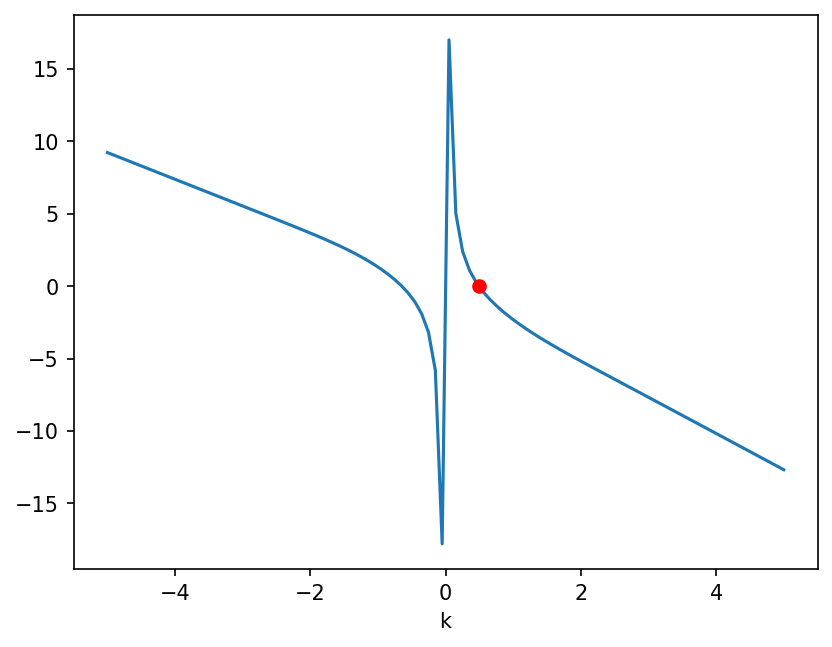

In [13]:
# root_function = lambda k: c_l * (Tw - Tm) * np.exp(-k**2) / erf(k) \
#     - np.sqrt(a_s / a_l) * c_s * (T1 - Tm) * np.exp(-k**2 * (a_l / a_s)) / erf(k * np.sqrt(a_l / a_s)) - k * L * np.sqrt(np.pi)

# root_function = lambda k: np.exp(-k**2) / erf(k) \
#     + lam_s / lam_l * np.sqrt(a_l / a_s) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erfc(k * np.sqrt(a_l / a_s)) \
#     + k * L * a_l * np.sqrt(np.pi) / lam_l / (Tw - Tm)

# root_function = lambda k: np.exp(-k**2) / erf(k) + lam_s / lam_l * np.sqrt(a_l / a_s) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erfc(k * np.sqrt(a_l / a_s)) - k * L * np.sqrt(np.pi) / c_l / (Tw - Tm)

# root_function = lambda k: np.exp(-k**2) / erf(k) \
#     - c_l / c_s * np.sqrt(a_s / a_l) * (Tm - T1) / (Tm - Tw) * np.exp(-k**2 * (a_l / a_s)) / erfc(k * np.sqrt(a_l / a_s)) \
#     + k * L * np.sqrt(np.pi) / c_l / (Tm - Tw)

# root_function = lambda k: np.exp(-k**2) / erf(k) \
#     - c_s / c_l * np.sqrt(a_s / a_l) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erf(k * np.sqrt(a_l / a_s)) \
#     - k * L * np.sqrt(np.pi) / c_l / (Tw - Tm)

# root_function = lambda k: np.exp(-k**2) / erf(k) \
#     - c_s / c_l * np.sqrt(a_s / a_l) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erf(k * np.sqrt(a_l / a_s)) \
#     - k * L * np.sqrt(np.pi) / c_l / (Tw - Tm)

root_function = lambda k: np.exp(-k**2) / erf(k) \
    + lam_s / lam_l * np.sqrt(a_l / a_s) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erfc(k * np.sqrt(a_l / a_s)) \
    - k * L * np.sqrt(np.pi) / c_l / (Tw - Tm)

ki = np.linspace(-5, 5, 100)
k = root(root_function, 2)["x"][0]

plt.plot(ki, root_function(ki))
plt.plot(k, root_function(k), 'ro')
plt.xlabel("k")
k, root_function(k)

In [14]:
plt.rcParams["figure.dpi"] = 150

Tws, ks = np.loadtxt("ks.csv", delimiter=',').T

fit_func = lambda T, a, b: a * np.log(T) + b

popt, popv = curve_fit(fit_func, Tws, ks, (10, 1))

x = np.linspace(min(Tws), max(Tws), 1000)

plt.plot(Tws, ks, 'o', label=f"numeriek")
plt.plot(x, fit_func(x, *popt), label=f"fit numeriek $k={popt[0]:.2f}\\cdot\\ln(T){popt[1]:.2f}$")

Tws = np.arange(100, 1050, 50)

ks = []

Twold = Tw
for Tw in Tws:
    ks.append(root(root_function, 0.45)["x"][0])
Tw = Twold

fit_func = lambda T, a, b: a * np.log(T) + b

popt, popv = curve_fit(fit_func, Tws, ks, (10, 1))

x = np.linspace(min(Tws), max(Tws), 1000)

plt.plot(Tws, ks, 'o', label="analytisch")
plt.plot(x, fit_func(x, *popt), label=f"fit analytisch $k={popt[0]:.2f}\\cdot\\ln(T){popt[1]:.2f}$")
plt.xlabel("$T$ ($\\degree$C)")
plt.ylabel("k")
plt.legend(loc="lower right")
plt.savefig("k_waardes.png", dpi=300)

TypeError: Improper input: func input vector length N=2 must not exceed func output vector length M=1

array([ 0.3813707, -1.3988136])

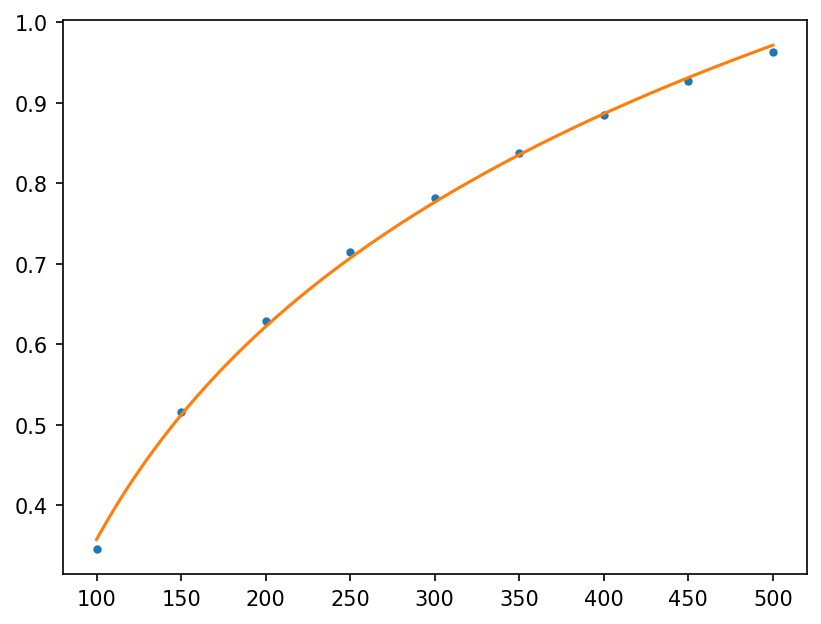

In [ ]:
Tws, ks = np.loadtxt("ks.csv", delimiter=',').T

fit_func = lambda T, a, b: a * np.log(T) + b

popt, popv = curve_fit(fit_func, Tws, ks, (10, 1))

x = np.linspace(min(Tws), max(Tws), 1000)

plt.plot(Tws, ks, '.')
plt.plot(x, fit_func(x, *popt))
popt

array([ 0.33214927, -0.77884122])

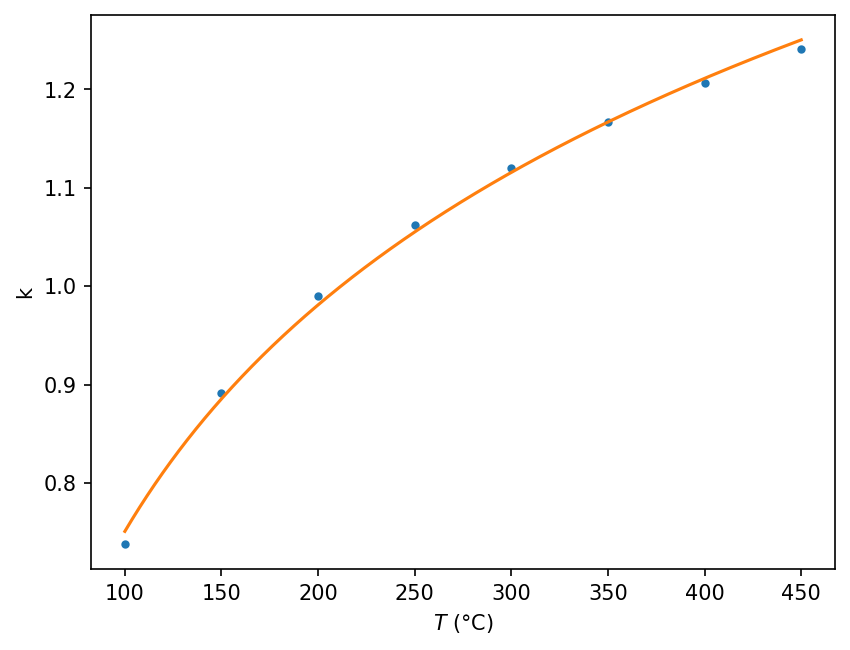

In [ ]:
Tws = np.arange(100, 500, 50)

ks = []

for Tw in Tws:
    ks.append(root(root_function, 0.45)["x"][0])

fit_func = lambda T, a, b: a * np.log(T) + b

popt, popv = curve_fit(fit_func, Tws, ks, (10, 1))

x = np.linspace(min(Tws), max(Tws), 1000)

plt.plot(Tws, ks, '.')
plt.plot(x, fit_func(x, *popt))
plt.xlabel("$T$ ($\\degree$C)")
plt.ylabel("k")
popt

In [ ]:
# k = 0.56

# def X_i(t):
#     return 2 * k * np.sqrt(a_s * t)

# def T(x, t):
#     if x < X_i(t):
#         return Tw + (Tm - Tw) * erf(x / 2 / np.sqrt(a_s * t)) / erf(k)
    
#     return T1 + (Tm - T1) * erfc(x / 2 / np.sqrt(a_l * t)) / erfc(k * np.sqrt(a_s / a_l))
k = 0.45352843824427835
def X_i(t):
    return 2 * k * np.sqrt(a_l * t)

def T(x, t):
    if t == 0:
        return np.full_like(x, T1)
    
    if x < X_i(t):
        return Tw + (Tm - Tw) * erf(x / 2 / np.sqrt(a_l * t)) / erf(k)
    
    return T1 + (Tm - T1) * erfc(x / 2 / np.sqrt(a_s * t)) / erfc(k * np.sqrt(a_l / a_s))

T = np.vectorize(T)

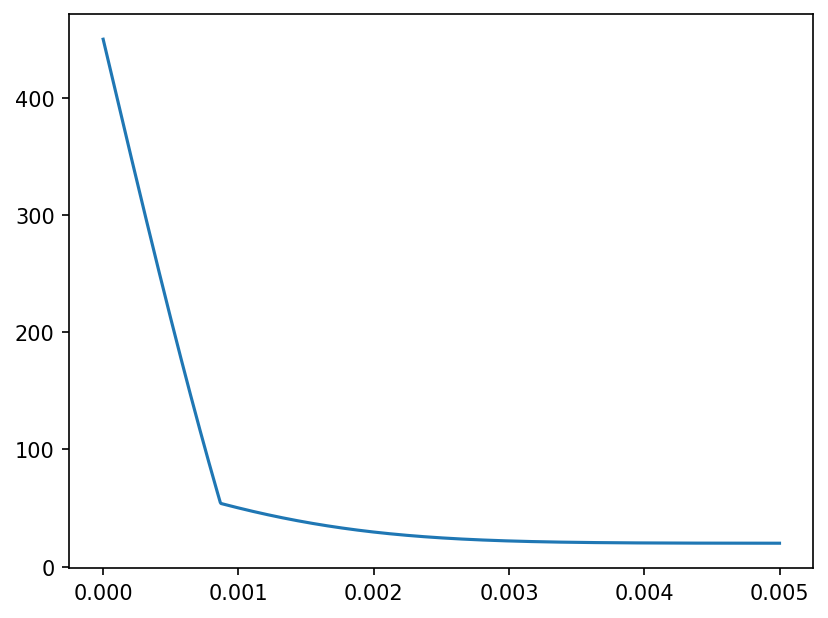

In [ ]:
x = np.linspace(0, w, 1000)
t = 10

plt.plot(x, T(x, t))

In [ ]:
dx = 1e-5
dt = 1e-4

# def dT_solid(T):
#     return a_s * dt / dx**2 * (T[2:] + T[:-2] - 2 * T[1:-1])

# dT_solid(np.array([100., 20., 20.]))

a_s * dt / dx**2

0.0962309542902967

k = 0.4640718768092583
k = 0.4658098267036424


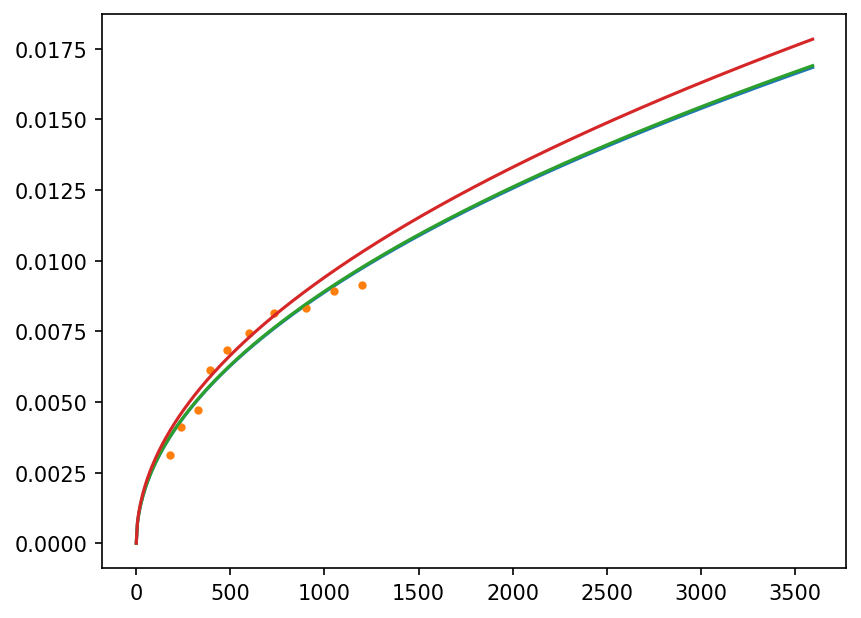

0.0018703068689121171


In [72]:
w       = 50e-3
dx      = 1e-4       # m
dt      = 1e-4       # s

x = np.arange(0, w, dx) # all cell positions
t1 = 3600. # simulation time to run for
N = int(t1 / dt) # number of iterations for simulation time

playback = 3600 / 30 # playback speed
fps = 20 # fps for animation
t_fps = 1 / fps / dt # number of iterations between each frame
frames = np.where(np.arange(N, dtype=int) % int(t_fps * playback) == 0)[0] # all iterations that are displayed

T = np.loadtxt("returnsT0=120.0,dT=0.5.csv", delimiter=',')
t_exp, s_exp = np.loadtxt("results_experiment_1.csv", delimiter=',').T
s_exp /= 1e3
# t_exp -= 120

s = [x[np.abs(T[i] - Tm).argmin()] for i in range(len(frames))]
t = frames * dt

fit_func = lambda t, k: 2 * k * np.sqrt(a_l * t)
fit_func_exp = lambda t, k, ds: 2 * k * np.sqrt(a_l * t) + ds

t1 = 1500
popt, popv = curve_fit(fit_func, t, s)
popt_exp, popv_exp = curve_fit(fit_func_exp, t_exp[t_exp < t1], s_exp[t_exp < t1], maxfev=10000)

print(f"k = {popt[0]}")
print(f"k = {popt_exp[0]}")

# plt.plot(t, s)
plt.plot(t, fit_func(t, *popt))
plt.plot(t_exp[t_exp < t1], s_exp[t_exp < t1] - popt_exp[1], '.')
plt.plot(t, fit_func_exp(t, *popt_exp) - popt_exp[1])
plt.plot(t, 2 * k * np.sqrt(a_l * t))

plt.show()
print(popt_exp[1])